## Introduction

This is the ***fourth*** of a series where I look at big datasets, and in each case I'm using a different tool to carry out the same analysis on the same dataset.

This time I'm using **Talend Open Studio**, an open source ETL tool. You can find each notebook in the series in my [Github repo](https://github.com/jlad26/london-smart-energy), including:
1. Pandas chunksize
1. Dask library
1. PySpark
1. Talend Open Studio

There is a little more explanation in the first notebook (Pandas chunksize) on the overall approach to the analysis. In the other notebooks I focus more on the elements specific to the tool being used.

## Dataset description

Throughout the series we'll use the [SmartMeter Energy Consumption Data in London Households](https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households) dataset, which according to the website contains:
>Energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014.

The households were divided into two groups:
- Those who were sent Dynamic Time of Use (dToU) energy prices (labelled "High", "Medium", or "Low") a day in advance of the price being applied.
- Those who were subject to the Standard tariff.

One aim of the study was to see if pricing knowledge would affect energy consumption behaviour.

## Results

<img src="images/result1-no-dupes.png" width="100%"/>

The results show the expected seasonal variation with a clear difference between the two groups, suggesting that energy price knowledge does indeed help reduce energy consumption.

The rest of the notebook shows how this chart was produced from the raw data.

## Introduction to Talend Open Studio

Talend Open Studio is a free ETL (Extract-Transform-Load) program. Here's how Talend describe it:

>With Talend Open Studio, you can begin building basic data pipelines in no time. Execute simple ETL and data integration tasks, get graphical profiles of your data, and manage files  — from a locally installed, open-source environment that you control.

Although we'll be carrying out largely the same operations as in the other notebooks, this time we'll be using the Talend GUI to create those operations, and where we need to use code it will be Java, not Python, as Open Studio runs on Java.

I will assume a basic knowledge of how to use Talend Open Studio, so this will not be a detailed how-to guide.

**NB** Please note also that this is just a training exercise for me - Talend may not be the best tool for some of the tasks presented here.

### Installation

The program is downloadable [here](https://www.talend.com/products/talend-open-studio/). I am using an old version 7.01 (because during my data science course our trainer used it saying it is reliable). Note you will also need Java installed - v11 is required for the latest version of Open Studio, while v8 works for older versions.

### Talend files

All the job files that I use are available in this Github repository in a zip file in the folder `Talend`. You should be able to import them as an archive into a Talend project and use them yourself with the data.

However, throughout this exercise you will see I use absolute filepaths. That's because a relative filepath for Talend is relative to its installation folder and that is not where I want to store data. That means you will need to adjust the filepaths for the jobs to work on your computer.

## Accessing the data

The data is downloadable as a single zip file which contains a csv file of 167 million rows. If the `curl` command doesn't work (and it will take a while as it's a file of 800MB), you can download the file [here](https://data.london.gov.uk/download/smartmeter-energy-use-data-in-london-households/3527bf39-d93e-4071-8451-df2ade1ea4f2/LCL-FullData.zip) and put it in the folder `data` which is in the folder where this notebook is saved.

In [ ]:
!curl "https://data.london.gov.uk/download/smartmeter-energy-use-data-in-london-households/3527bf39-d93e-4071-8451-df2ade1ea4f2/LCL-FullData.zip" --location --create-dirs -o "data/LCL-FullData.zip"

First we unzip the data. This may take a while! Alternatively you can unzip it manually using whatever unzip utility you have. Just make sure the extracted file is in a folder called `data` within the folder where your notebook is saved.

In [1]:
!unzip "data/LCL-FullData.zip" -d "data"

Archive:  data/LCL-FullData.zip
  inflating: data/CC_LCL-FullData.csv  


## Examining the data

First we'll create a test file - a file containing a small subset of the data. For this job "Job_Create_Test_File" we use a tFileInputDelimited component and a tFileOutputDelimited component. The important setting is shown near the bottom of the screenshot for the tFileInputDelimited component - the Limit is set to 1,000,000 rows.

### Job_Create_Test_File

**tFileInputDelimited - Raw_Data_File**

<img src="images/Talend-Job_Create_Test_File-tFileInputDelimited.png" width="100%"/>

**tFile_Output_Delimited - Test_Data_File**

We save our output file of 1,000,000 rows as "test-data.csv".

<img src="images/Talend-Job_Create_Test_File-tFileOutputDelimited.png" width="100%"/>

And now we can view the file using Pandas.

In [2]:
import pandas as pd

In [3]:
test_data = pd.read_csv("data/test-data.csv")

In [4]:
test_data

,LCLid,stdorToU,DateTime,KWH_hh__per_half_hour_
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0
...,...,...,...,...
999995,MAC000036,Std,2012-11-08 08:00:00.0000000,0.228
999996,MAC000036,Std,2012-11-08 08:30:00.0000000,0.042
999997,MAC000036,Std,2012-11-08 09:00:00.0000000,0.076
999998,MAC000036,Std,2012-11-08 09:30:00.0000000,0.07


Now we check for duplicates in our test data using a tUniqRow component and a tLogRow component. The results show we have duplicates that will need to be removed.

<img src="images/Talend-Job_Check_For_Dupes.png" width="100%"/>

Let's also check the aggregation. We're going to aggregate the half-hourly data into daily data, so for that we'll use a tMap and a tAggregateRow.

<img src="images/Talend-Job_Check_Aggregation.png" width="100%"/>

**tMap Settings**

Note:
- I changed the Type of kWh in the Test_Data_File tFileInputDelimited component from `String` to `Float` as we expect them to be decimal numbers.
- I have used an expression to convert the DateTime values to Date values, but for simplicity we are keeping them as type `String`.

<img src="images/Talend-Job_Check_Aggregation-tMap_Settings.png" width="100%"/>

**tAggregateRow settings**

We group by `Household_ID`, `Tariff_Type`, and `Date` and sum the kWh data.

<img src="images/Talend-Job_Check_Aggregation-tAggregateRow_Settings.png" width="100%"/>

When we execute however, the tLogRow shows us some errors as well as some successful aggregation.

<img src="images/Talend-Job_Check_Aggregation-tLogRow_Output.png" />

The error message tells us we have some `"Null"` values which we will have to remove.

We remove them using a tFilterRow component. Note however that I have reset the `kWh` data type back to `String` for the Test_Data_File tFileInputDelimited component and for the tFilterRow component. Then we can set the tFilterRow to pass on all kWh values that are not equal to `"Null"`.

<img src="images/Talend-Job_Check_Aggregation_Removing_Nulls-tFilterRow_Settings.png" />

The tMap is unchanged except for the transformation of kWh from type `String` to type `Float` using the functions `Float.parseFloat()`.

<img src="images/Talend-Job_Check_Aggregation_Removing_Nulls-tMap_Settings.png" />

Now when we run we get no errors.

## Aggregating the test data

The overall process for the test data is then as shown below:
- Remove duplicates using a tUniqRow.
- Remove nulls using a tFilterRow.
- Convert timestamp to date and kWh from `String` to `Float` using a tMap.
- Aggregate using a tAggregate row.
- Output to a csv (test-out.csv).

<img src="images/Talend-Job_Entire_Process_No_Batch.png" />

We can read the results into pandas.

In [5]:
test_summary_data = pd.read_csv("data/test-out.csv")

In [6]:
test_summary_data.sort_values(['Household_ID', 'Tariff_Type', 'Date'])

,Household_ID,Tariff_Type,Date,kWh
14463,MAC000002,Std,2012-10-12,7.098
14464,MAC000002,Std,2012-10-13,11.087
14440,MAC000002,Std,2012-10-14,13.223
14443,MAC000002,Std,2012-10-15,10.257
14446,MAC000002,Std,2012-10-16,9.769
...,...,...,...,...
19879,MAC000036,Std,2012-11-04,2.401
19870,MAC000036,Std,2012-11-05,2.379
19873,MAC000036,Std,2012-11-06,2.352
19885,MAC000036,Std,2012-11-07,2.599


This works fine on the test data. But when we run it on the full data we quickly encounter memory errors. After testing various approaches, my conclusions were:
1. The deduplication is the most memory-intensive operation.
1. Even when using techniques like increasing the maximum available memory for the job (see [here](https://help.talend.com/r/en-US/7.2/studio-user-guide-data-integration/specifying-limits-of-vm-memory-for-job-or-route)) and using the Use of disk setting for the tUniqRow component (see in the Advanced Settings [here](https://help.talend.com/r/en-US/7.2/deduplication/tuniqrow-standard-properties)), the task still failed for lack of memory.
1. The solution I found - (there may be well better) - was to split the initial file into several files. However for deduplication to work the splits have to be located so that there cannot be duplicates between files, only within each file. For that we'll look at splitting by household ID or by year-month. Either approach guarantees no duplicates between files.

**Unique Household IDs**

Below is the process used to generate a list of unique household IDs.

<img src="images/Talend-Job_Generate_Household_ID_List.png" />

Note the schema of the tUniqRow component has only Household_ID as its output.

We can view the list as a Pandas dataframe.

In [7]:
household_ids = pd.read_csv("data/unique-household-ids.csv", header=None, names=['Household IDs'])

In [8]:
household_ids.sort_values(['Household IDs']).reset_index(drop=True)

,Household IDs
0,MAC000002
1,MAC000003
2,MAC000004
3,MAC000005
4,MAC000006
...,...
5561,MAC005563
5562,MAC005564
5563,MAC005565
5564,MAC005566


**Unique year months**

Below is the process to generate the year months.

<img src="images/Talend-SubJob_Generate_Year_Month_List.png" />

In the tMap we use a StringHandling function to convert the timestamp to a year-month format.

<img src="images/Talend-SubJob_Generate_Year_Month_List-tMap_Settings.png" />

The output shows that we have 28 unique months.

In [9]:
year_months = pd.read_csv("data/unique-year-month.csv", header=None, names=['Year-Month'])

In [10]:
year_months.sort_values(['Year-Month']).reset_index(drop=True)

,Year-Month
0,2011-11
1,2011-12
2,2012-01
3,2012-02
4,2012-03
5,2012-04
6,2012-05
7,2012-06
8,2012-07
9,2012-08


Splitting by year-month seems a sensible approach - easy to do and divides into a reasonable number of files.

## Processing the full data

These are the steps used to process the full data:
1. Generate list of unique year-months (as above).
1. Use the list of unique year-months to iterate through the full data generating an individual file for each month of data (28 in all).
1. Deduplicate in each of the 28 year-month files.
1. For each of the 28 year-month files: Remove nulls; Group by `Household_ID`, `Tariff_Type` and `Date` and sum `kWh`; Save the aggregated results a new file.
1. Merge the 28 aggregated files into one.

The overall process is slow, particularly the splitting of the original file, as we iterate through the whole dataset 28 times. There are almost certainly better ways of doing this! The entire process from beginning to end takes about an hour and a half to run on my laptop.

### 1. Generate list of unique year-months

Done above.

### 2. Split original file into year-month files

<img src="images/Talend-SubJob_Split_File_By_Year_Month.png" />

We use a tFlowToIterate component to iterate over the full data 28 times, each time filtering the raw data by the year month.

**tMap - Add_Year_Month_Col Settings**

We use the tMap to add in the `Year_Month` column using the StringHandling function.

<img src="images/Talend-SubJob_Split_Files_By_Year_Month-tMap_Settings.png" />

**tFilterRow - Filter_By_Year_Month Settings**

We use the advanced mode of the tFilterRow component to filter by the `Year_Month` value that has been set by the tFlowToIterate component.

<img src="images/Talend-SubJob_Split_Files_By_Year_Month-tFilterRow_Settings.png" />

**tFileOutputDelimited - Year_Month_File Settings**

We also use the stored `Year_Month` value to set the filename of each of the 28 files produced. Note that the code  `((String)globalMap.get("Unique_Year_Months.Year_Month"))` can be generated automatically by dragging and dropping the `Year_Month - Year_Month (After)` element of the tFlowIterate component from the left-hand window into the File Name field in the right-hand window.

<img src="images/Talend-SubJob_Split_Files_By_Year_Month-tFileOutputDelimited_Settings.png" />

### 3. Deduplicate in each of the year-month files

We use a tFileList component to iterate over the 28 year-month files and remove duplicates from each one, saving to a new file.

<img src="images/Talend-SubJob_Deduplicate_Chunk_Files.png" />

**tFileInputDelimited - Sub_File Settings**

We can drag the `Current File Name with path - CURRENT_FILEPATH (Flow)` from the left-hand window into the File name/Stream field in the right hand window to generate the code in that field.

<img src="images/Talend-SubJob_Deduplicate_Chunk_Files-tFileInputDelimited_Settings.png" />

**tUniqRow - Remove_Duplicates Settings (Basic and Advanced)**

<img src="images/Talend-SubJob_Deduplicate_Chunk_Files-tUniqRow_Settings.png" />

Note that we use the Use of disk setting in Advanced settings to reduce the memory requirements.

<img src="images/Talend-SubJob_Deduplicate_Chunk_Files-tUniqRow_Advanced_Settings.png" />

**tFileOutputDelimited - Deduplicated_File Settings**

We use a similar drag-drop to generate the filename for the deduplicated file.

<img src="images/Talend-SubJob_Deduplicate_Chunk_Files-tFileOutputDelimited_Settings.png" />

**Job execution settings**

For this job I changed the execution settings to increase the Java Virtual Machine memory allocation - raising the initial memory allocation from the default of 256MB `-Xms256M` to 1GB `-Xms1024M` and the maximum allocation from the default of 1GB `-Xmx1024M` to 4GB `-Xmx4096M`. It may have been possible to avoid this by reducing the buffer size of the "Use of disk" tUniqRow setting.

<img src="images/Talend-SubJob_Deduplicate_Chunk_Files-Execution_Settings.png" />

### 4. Remove nulls and aggregate by year-month

<img src="images/Talend-SubJob_Process_Chunk_Files.png" />

The Remove_Nulls tFilterRow component and the Preprocess tMap component have the same settings as their equivalents in the test data aggregation process. However the aggregation had to be handled differently because a single tAggregateRow component would cause Out of memory errors. The answer was to use a tSortRow component and then a tAggregateSortedRow component as this reduced memory requirements. It was also necessary to use the Sort on disk option for the tSortRow component to further reduce memory load.

**tSortRow - Sort Settings (Basic and Advanced)**

<img src="images/Talend-SubJob_Process_Chunk_Files-tSortRow_Settings.png" />

<img src="images/Talend-SubJob_Process_Chunk_Files-tSortRow_Advanced_Settings.png" />

**tAggregateSortedRow - Aggregate_Sorted Settings**

The tAggregateSortedRow component needs to know the number of input rows. We can get that by dragging the `Number of line matching the filter - NB_LINE_OK (After)` element of the tFilterRow component in the left-hand window into the Input rows count field in the right-hand window.

<img src="images/Talend-SubJob_Process_Chunk_Files-tAggregatedSortedRow_Settings.png" />

### 5. Merge the processed year-month files into a single file

<img src="images/Talend-SubJob_Merge_Processed_Files.png" />

**tFileInputDelimited - Aggrgated_Chunk_File Settings**

<img src="images/Talend-SubJob_Merge_Processed_Files-tFileInputDelimited_Settings.png" />

### Viewing the results

We can access the resulting data in a Pandas dataframe.

In [11]:
daily_summary = (
    pd.read_csv("data/merged-processed-chunks.csv").sort_values(
        ['Household_ID', 'Tariff_Type', 'Date']
    )
    .reset_index(drop=True)
    .rename(columns = {
        'Household_ID' : 'Household ID',
        'Tariff_Type' : 'Tariff Type'
    })
)

In [12]:
daily_summary

,Household ID,Tariff Type,Date,kWh
0,MAC000002,Std,2012-10-12,7.098
1,MAC000002,Std,2012-10-13,11.087
2,MAC000002,Std,2012-10-14,13.223
3,MAC000002,Std,2012-10-15,10.257
4,MAC000002,Std,2012-10-16,9.769
...,...,...,...,...
3510398,MAC005567,Std,2014-02-24,4.107
3510399,MAC005567,Std,2014-02-25,5.762
3510400,MAC005567,Std,2014-02-26,5.066
3510401,MAC005567,Std,2014-02-27,3.217


## Saving aggregated data

Now that we have reduced the data down to about 3 million rows it should be managable in a single dataframe. It's useful to save the data so that we don't have to re-run the aggregation every time we want to work on the aggregated data.

We'll save it in a compressed gz format - pandas automatically recognizes the filetype we specify.

In [13]:
daily_summary.to_csv("data/daily-summary-data.gz", index=False)

## Overall process coordination

To run all the jobs in a single go we have a Process_Coordinator job which executes the jobs in sequence. There are also various tJava elements in the subjobs which output progress information to the console while jobs are being executed.

<img src="images/Talend-Job_Process_Coordinator.png" />

The rest of this notebook is now essentially the same processing as applied in all the other notebooks in the series.

## Analysing the data

In [14]:
saved_daily_summary = pd.read_csv("data/daily-summary-data.gz")

In [15]:
saved_daily_summary

,Household ID,Tariff Type,Date,kWh
0,MAC000002,Std,2012-10-12,7.098
1,MAC000002,Std,2012-10-13,11.087
2,MAC000002,Std,2012-10-14,13.223
3,MAC000002,Std,2012-10-15,10.257
4,MAC000002,Std,2012-10-16,9.769
...,...,...,...,...
3510398,MAC005567,Std,2014-02-24,4.107
3510399,MAC005567,Std,2014-02-25,5.762
3510400,MAC005567,Std,2014-02-26,5.066
3510401,MAC005567,Std,2014-02-27,3.217


Out of interest let's see what sort of data coverage we have. First we re-organize so that we have households as columns and dates as rows.

In [16]:
summary_table = saved_daily_summary.pivot_table(
    'kWh',
    index='Date',
    columns='Household ID',
    aggfunc='sum'
)

Then we can plot where we have data (black) and where we don't (white).

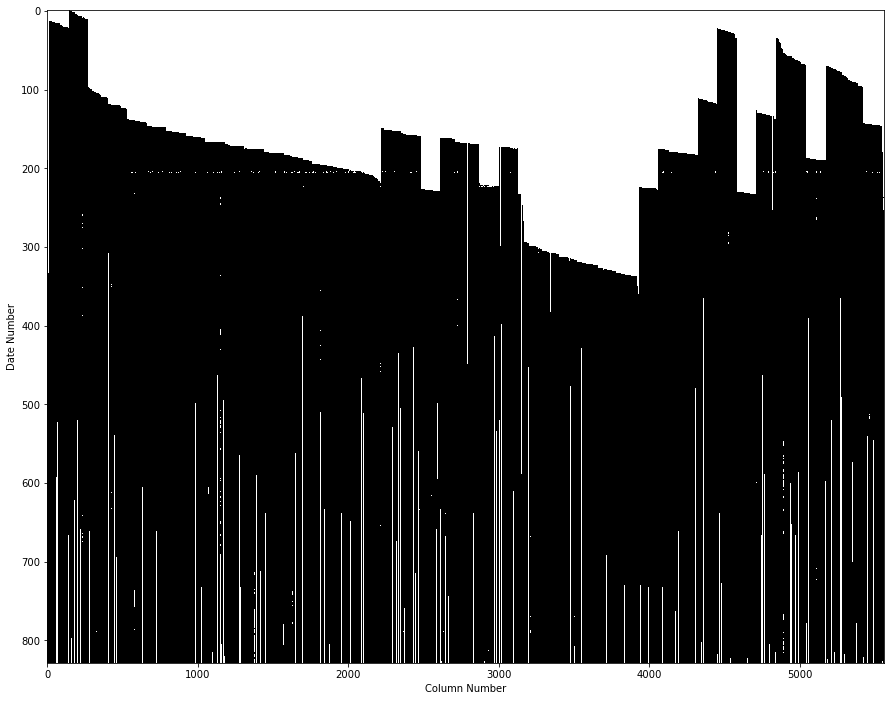

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
plt.imshow(summary_table.isna(), aspect="auto", interpolation="nearest", cmap="gray")
plt.xlabel("Column Number")
plt.ylabel("Date Number");

Despite a slightly patchy data coverage, averaging by tariff type across all households for each day should give us a useful comparison.

In [18]:
daily_mean_by_tariff_type = saved_daily_summary.pivot_table(
    'kWh',
    index='Date',
    columns='Tariff Type',
    aggfunc='mean'
)
daily_mean_by_tariff_type

Tariff Type,Std,ToU
Date,,
2011-11-23,7.430000,4.327500
2011-11-24,8.998333,6.111750
2011-11-25,10.102885,6.886333
2011-11-26,10.706257,7.709500
2011-11-27,11.371486,7.813500
...,...,...
2014-02-24,10.580187,9.759439
2014-02-25,10.453365,9.683862
2014-02-26,10.329026,9.716652


Finally we can plot the two sets of data. The plotting works better if we convert the date from type `string` to type `datetime`.

In [19]:
daily_mean_by_tariff_type.index = pd.to_datetime(daily_mean_by_tariff_type.index)

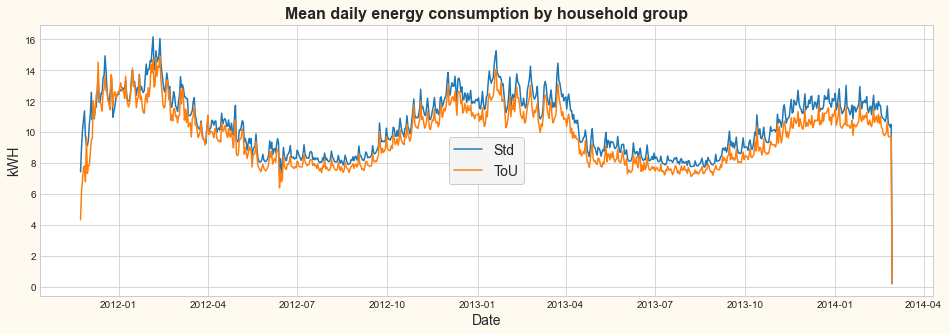

In [20]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(16, 5), facecolor='floralwhite')
for tariff in daily_mean_by_tariff_type.columns.to_list():
    plt.plot(
        daily_mean_by_tariff_type.index.values,
        daily_mean_by_tariff_type[tariff],
        label = tariff
    )

plt.legend(loc='center', frameon=True, facecolor='whitesmoke', framealpha=1, fontsize=14)
plt.title(
    'Mean daily energy consumption by household group',
    fontdict = {'fontsize' : 16, 'fontweight' : 'bold'}
)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('kWH', fontsize = 14)
plt.show()

The pattern looks seasonal which makes sense given heating energy demand.

It also looks like there's a difference between the two groups with the ToU group tending to consume less, but the display is too granular. Let's aggregate again into months.

In [21]:
daily_mean_by_tariff_type

Tariff Type,Std,ToU
Date,,
2011-11-23,7.430000,4.327500
2011-11-24,8.998333,6.111750
2011-11-25,10.102885,6.886333
2011-11-26,10.706257,7.709500
2011-11-27,11.371486,7.813500
...,...,...
2014-02-24,10.580187,9.759439
2014-02-25,10.453365,9.683862
2014-02-26,10.329026,9.716652


We can see that the data starts partway through November 2011, so we'll start from 1 December. It looks like the data finishes perfectly at the end of February, but the last value looks suspiciously low compared to the others. It seems likely the data finished part way through the last day. This may be a problem elsewhere in the data too, but it shouldn't have an enormous effect as at worst it will reduce the month's energy consumption for that household by two days (one at the beginning and one at the end).

In [22]:
monthly_mean_by_tariff_type = daily_mean_by_tariff_type['2011-12-01' : '2014-01-31'].resample('M').sum()
monthly_mean_by_tariff_type

Tariff Type,Std,ToU
Date,,
2011-12-31,377.218580,365.145947
2012-01-31,401.511261,386.016403
2012-02-29,395.065321,368.475150
2012-03-31,349.153085,330.900633
2012-04-30,314.173857,296.903425
2012-05-31,281.666428,263.694338
2012-06-30,257.204029,238.417505
2012-07-31,260.231952,244.641359
2012-08-31,253.939017,238.904097


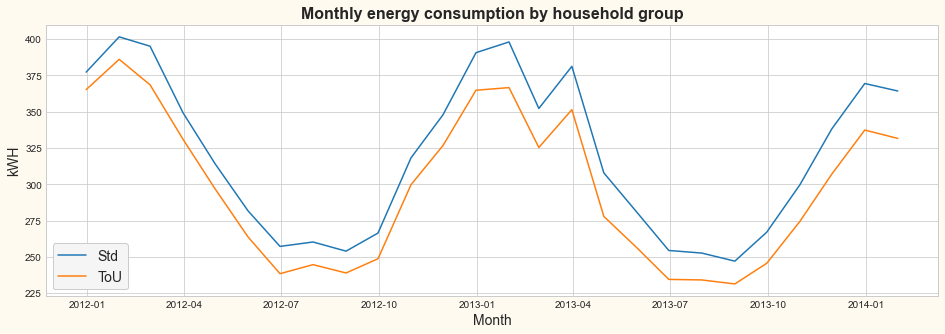

In [23]:
plt.figure(figsize=(16, 5), facecolor='floralwhite')
for tariff in daily_mean_by_tariff_type.columns.to_list():
    plt.plot(
        monthly_mean_by_tariff_type.index.values,
        monthly_mean_by_tariff_type[tariff],
        label = tariff
    )

plt.legend(loc='lower left', frameon=True, facecolor='whitesmoke', framealpha=1, fontsize=14)
plt.title(
    'Monthly energy consumption by household group',
    fontdict = {'fontsize' : 16, 'fontweight' : 'bold'}
)
plt.xlabel('Month', fontsize = 14)
plt.ylabel('kWH', fontsize = 14)

# Uncomment for a copy to display in results
# plt.savefig(fname='images/result1-no-dupes.png', bbox_inches='tight')

plt.show()

The pattern is much clearer and there is an obvious difference between the two groups of consumers.

Note that the chart does not show mean monthly energy consumption, but the sum over each month of the daily means. To calculate true monthly means we would need to drop the daily data for each household where the data was incomplete for a month. Our method should give a reasonable approximation.